In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [93]:
#Constants
M = 100
R= 10
T=2
N=1000
sigma=1/5
r=0.02
c=1
K_eur=10
H_eur=0
K_but = 1
H_but = 3
K_bin = 1
H_bin = 3

### Initial Conditions

In [97]:
def european_put(x):
    europe=np.array(K_eur-x)
    europe[int((K_eur*M)/R):]=0
    return europe

def butterfly(x):
    term1=np.array(x-K_but) #First term
    for i in range(len(term1)):
        term1[n] = max(term1[n], 0)
        
    term1[:int((K_but*M)/R)]=0
    term2=2*np.array(x-(K_but+H_but)) #Second term
    term2[:int(((K_but+H_but)*M)/R)]=0
    term3=np.array(x-(K_but+2*H_but)) #Third term
    term3[:int(((K_but+2*H_but)*M)/R)]=0
    butterfly=term1-term2+term3
    return butterfly

def binary(x, strike_K, strike_H, R, M):
    arr=np.ones(len(x))
    indices=np.where(x-strike_K<0)
    np.put(arr, indices, 0)
    return arr

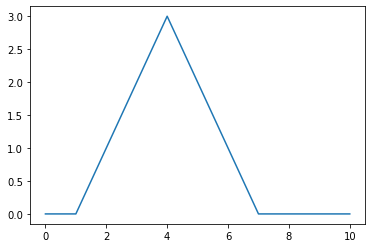

In [105]:
x=np.linspace(0, R, (M+1))  
c= butterfly(x)
plt.plot(x,c)
#plt.vlines(H_but,0,3)

In [109]:
y=5-x
y=np.max(y, np.zeros(len(y)))
plt.plot(x,y)

TypeError: only integer scalar arrays can be converted to a scalar index

#### Boundary conditions

In [74]:
def boundary_0(t, K=K_eur):                  #How to choose this c value?
    return K*np.exp(-c*t)

def boundary_R_eur(t, K=K_eur):
    return max((K-R), 0)

In [7]:
#Practical
def tridiag(lower, diag, upper, size):
    A=np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)
    return A
tridiag([2,2,2], [3, 3, 3, 3], [4, 4, 4], 4)

array([[3, 4, 0, 0],
       [2, 3, 4, 0],
       [0, 2, 3, 4],
       [0, 0, 2, 3]])

In [89]:
def forward_euler(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, RHS_func = lambda x, t: 0*x):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    
    U=np.zeros((M+1, N+1))        #How to choose M?   MxN matrix still, easier plots
    x=np.linspace(0, R, (M+1))    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=initial_func(x) #Initial and boundary functions
    U[0, :]=BC0(t)
    U[-1,:]=BCR(R)
    
    tt, xx = np.meshgrid(t,x)
    F = RHS_func(tt,xx)
    
    beta_neg1 = k*sigma**2*m[2:-1]**2/2 - k*r*m[2:-1]/2
    beta_0 = 1-k*sigma**2*m[1:-1]**2 - k*c
    beta_1 = k*sigma**2*m[1:-2]**2/2 + k*r*m[1:-2]/2
    
    A=tridiag(beta_neg1, beta_0 ,beta_1, M-1)
           
    CFL=np.diag(A)
    
    for n in range(N):
        U[1:-1, n+1]=A.dot(U[1:-1, n])
    
    return U, CFL

In [90]:
U, CFL = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, boundary_0, boundary_R_eur, 
                  european_put, RHS_func = lambda x, t: 0*x)

In [52]:
x=np.linspace(0, R, (M+1))    #Remember to add stability condition with positive coefficient in tridiag
t=np.linspace(0, T, N+1)

tt, xx = np.meshgrid(t,x)

def F(t, x):
    return t + x**2
Z = F(tt,xx)

In [50]:
def plot_solution(U):
    x_len = len(U[:,])
    t_len = len(U[0])
    
    x=np.linspace(0, R, x_len) 
    t=np.linspace(0, T, t_len)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), subplot_kw={"projection": "3d"})
    tt, xx = np.meshgrid(t, x)
    ax.plot_surface(tt, xx, U, cmap=cm.coolwarm)
    ax.view_init(azim=50)              # Rotate the figure
    ax.set_title('European put')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    fig.tight_layout()

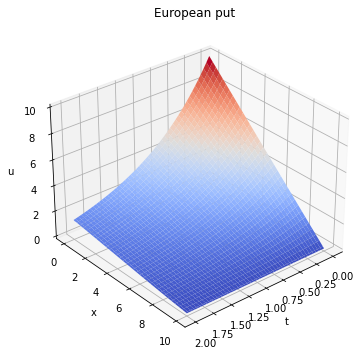

In [91]:
plot_solution(U)